In [1]:
# Import libraries
import os
import warnings
import pandas as pd
import tqdm
import numpy as np
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat
import socceraction.vaep.features as fs

# Set pandas options and warnings filters
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

In [2]:
# Load StatsBomb data
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

# La Liga
selected_competitions = competitions[
    (competitions.competition_name == "Premier League")
    & (competitions.season_name == "2015/2016")
]
selected_competitions

print(selected_competitions)

    season_id  competition_id competition_name country_name  \
64         27               2   Premier League      England   

   competition_gender season_name  
64               male   2015/2016  


In [3]:
# Get game data from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}

for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(
        events,
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

Loading game data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [14:58<00:00,  2.36s/it]


In [4]:
# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [5]:
# Configure file and folder names, use SPADL format.
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
xT_h5 = os.path.join(datafolder, "xT.h5")

In [6]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print(teams)

nb of games: 380
   team_id             team_name
0       28       AFC Bournemouth
1       22        Leicester City
0       27  West Bromwich Albion
1       41            Sunderland
0       59           Aston Villa
1       37      Newcastle United
1       29               Everton
0       23               Watford
1       31        Crystal Palace
0        1               Arsenal
0       24             Liverpool
0       38     Tottenham Hotspur
0       36       Manchester City
0       56          Norwich City
0       33               Chelsea
0       39     Manchester United
1       30            Stoke City
1       40       West Ham United
1       26          Swansea City
1       25           Southampton


In [7]:
# Read in all actions of games
A = []

with pd.HDFStore(spadl_h5) as spadlstore:
    for game in tqdm.tqdm(list(games.itertuples())):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        actions = spadl.add_names(actions)
        actions = spadl.play_left_to_right(actions, game.home_team_id)
        A.append(actions)
A = pd.concat(A)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:25<00:00, 14.71it/s]


Load pre-trained model

uncomment the lines below if you get an SSLError
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

Train a custom model

In [9]:
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A);

# iterations:  40


Compute xT-ratings

# Predict

In [10]:
# xT should only be used to value actions that move the ball
# and also keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.rate(mov_actions)
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,52.9375,34.340,52.4125,31.365,-0.001502
1,dribble,52.4125,31.365,52.4125,31.365,0.000000
2,pass,52.4125,31.365,41.5625,32.980,-0.001041
3,pass,41.5625,32.980,32.3750,3.740,-0.003085
4,dribble,32.3750,3.740,32.3750,5.015,0.000000
5,pass,32.3750,5.015,23.5375,19.040,0.000564
6,dribble,23.5375,19.040,23.5375,14.110,-0.000199
7,pass,23.5375,14.110,30.2750,2.295,-0.000366
8,dribble,30.2750,2.295,26.1625,2.125,-0.000634
9,pass,26.1625,2.125,14.1750,4.250,-0.000740


In [12]:
# Merge & rename dataframes
mov_actions = mov_actions.merge(
    games[['home_team_id', 'home_team_name']].rename(columns={'home_team_name': 'team_name'}),  
    left_on='team_id',                         
    right_on='home_team_id',                   
    how='left'
)
mov_actions = mov_actions.drop_duplicates(subset="original_event_id")

          game_id                     original_event_id  period_id  \
0         3754058  2ca23eea-a984-47e4-8243-8f00880ad1c9          1   
19        3754058  a936e18c-3979-4576-8cc0-94114f1599db          1   
38        3754058  0fee7719-7e69-49c5-be81-3f2b77da604e          1   
57        3754058  6362aa69-892f-4d11-8644-21a680ea7c66          1   
76        3754058  d031d1d6-600c-4234-ac87-8e9eb9efdeee          1   
...           ...                                   ...        ...   
10491515  3754078  86ea2a73-2206-40c5-a4c2-8752aa680db9          2   
10491534  3754078  4d000876-e324-4e38-b08d-7131564408a8          2   
10491553  3754078  8cf002ff-68ff-44a5-8882-56d2bd753075          2   
10491572  3754078  88aafe86-2436-4bc4-b396-49bb0c928656          2   
10491591  3754078  05a25779-e472-4f3c-a838-1b95397bc7fb          2   

          time_seconds  team_id  player_id  start_x  start_y    end_x   end_y  \
0                1.753       28     3343.0  52.9375   34.340  52.4125  31.365 

In [13]:
import matplotsoccer as mps

In [16]:
# Select relevant columns
games_df = games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]].copy()

# Calculate points
def get_points(home_score, away_score):
    if home_score > away_score:
        return 3, 0  # Home team wins
    elif home_score < away_score:
        return 0, 3  # Away team wins
    else:
        return 1, 1  # Draw

games_df["home_points"], games_df["away_points"] = zip(*games_df.apply(lambda row: get_points(row["home_score"], row["away_score"]), axis=1))

# DataFrame for home teams
home_stats = games_df.rename(columns={
    "home_team_id": "team_id",
    "home_score": "goals_for",
    "away_score": "goals_against",
    "home_points": "endpoints"
}).drop(columns=["away_team_id", "away_points"])

# DataFrame for away teams
away_stats = games_df.rename(columns={
    "away_team_id": "team_id",
    "away_score": "goals_for",
    "home_score": "goals_against",
    "away_points": "endpoints"
}).drop(columns=["home_team_id", "home_points"])

# Merge
all_stats = pd.concat([home_stats, away_stats])

# Calculate final table
league_table = all_stats.groupby("team_id").agg(
    games_played=("team_id", "count"),
    wins=("endpoints", lambda x: (x == 3).sum()),
    draws=("endpoints", lambda x: (x == 1).sum()),
    losses=("endpoints", lambda x: (x == 0).sum()),
    goals_for=("goals_for", "sum"),
    goals_against=("goals_against", "sum"),
    endpoints=("endpoints", "sum")
).reset_index()

# Add goal difference
league_table["goal_difference"] = league_table["goals_for"] - league_table["goals_against"]

# Sort by points & goal difference
league_table = league_table.sort_values(by=["endpoints", "goal_difference"], ascending=[False, False])

# Add team names
league_table = league_table.merge(teams, on="team_id", how="left")

# Rearrange columns
league_table = league_table[["team_name", "games_played", "wins", "draws", "losses", 
                             "goals_for", "goals_against", "goal_difference", "endpoints"]]

               team_name  games_played  wins  draws  losses  goals_for  \
0         Leicester City            38    23     12       3         68   
1                Arsenal            38    20     11       7         65   
2      Tottenham Hotspur            38    19     13       6         69   
3        Manchester City            38    19      9      10         71   
4      Manchester United            38    19      9      10         49   
5            Southampton            38    18      9      11         59   
6        West Ham United            38    16     14       8         65   
7              Liverpool            38    16     12      10         63   
8             Stoke City            38    14      9      15         41   
9                Chelsea            38    12     14      12         59   
10               Everton            38    11     14      13         59   
11          Swansea City            38    12     11      15         42   
12               Watford            38

In [17]:
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

# Extract competition title
wettbewerbsname = selected_competitions["competition_name"].iloc[0]

# Create export folder
output_dir = "/Users/andreas/Desktop/Spieltagsergebnisse"
os.makedirs(output_dir, exist_ok=True)

df = pd.DataFrame(mov_actions)

# Summing up xT-values per team and game
team_xT_per_game = df.groupby(['game_id', 'team_name'])['xT_value'].sum().reset_index()

# Merge dataframes based on 'game_id'
df_merged = pd.merge(games, team_xT_per_game, on='game_id', how='inner')

def poisson_prob(lambda_, k):
    return stats.poisson.pmf(k, lambda_)

def calculate_points(group):
    teams = group[['team_name', 'xT_value']]
    team_names = teams['team_name'].tolist()
    xT_values = teams['xT_value'].tolist()
    
    max_goals = 10  # Assumption: Max 10 goals per team
    probabilities = {team: [poisson_prob(xT_value, k) for k in range(max_goals + 1)] for team, xT_value in zip(team_names, xT_values)}
    
    points = {team: 0 for team in team_names}
    
    for goals_A in range(max_goals + 1):
        for goals_B in range(max_goals + 1):
            prob = probabilities[team_names[0]][goals_A] * probabilities[team_names[1]][goals_B]
            
            if goals_A > goals_B:
                points[team_names[0]] += prob * 3
            elif goals_A < goals_B:
                points[team_names[1]] += prob * 3
            else:
                points[team_names[0]] += prob * 1
                points[team_names[1]] += prob * 1
    
    return list(points.items())

# Get gameday from 'game_day'
unique_game_days = df_merged['game_day'].unique()
spieltag_ergebnisse = []
cumulative_points = pd.DataFrame(columns=["team_name", "points", "xT_plus", "xT_minus"])  # Leere Punkte-Tabelle
results_pear_df = pd.DataFrame(columns=["Spieltag", "Pearson Punktekorrelation", "p-Wert Pearson", "Wettbewerb"])

# Processing per gameday
for spieltag in sorted(unique_game_days):
    # Select games
    spieltag_games = df_merged[df_merged["game_day"] == spieltag]
    spieltag_game_ids = spieltag_games["game_id"].unique()

    # Calculate xT values
    team_xT_per_game_spieltag = df[df["game_id"].isin(spieltag_game_ids)].groupby(['game_id', 'team_name'])['xT_value'].sum().reset_index()

    # Calculate results
    results_spieltag = team_xT_per_game_spieltag.groupby('game_id').apply(
        lambda group: pd.DataFrame({
            'game_id': group['game_id'].iloc[0],
            'team_1': group.iloc[0]['team_name'],
            'xT_value_1': group.iloc[0]['xT_value'],
            'team_2': group.iloc[1]['team_name'],
            'xT_value_2': group.iloc[1]['xT_value'],
            'points_1': next(p for t, p in calculate_points(group) if t == group.iloc[0]['team_name']),
            'points_2': next(p for t, p in calculate_points(group) if t == group.iloc[1]['team_name']),
        }, index=[0]) if len(group) == 2 else None
    ).dropna().reset_index(drop=True)

    # Extract points
    points_spieltag = pd.concat([
        results_spieltag[["team_1", "points_1", "xT_value_1", "xT_value_2"]].rename(columns={"team_1": "team_name", "points_1": "points", "xT_value_1": "xT_plus", "xT_value_2": "xT_minus"}),
        results_spieltag[["team_2", "points_2", "xT_value_2", "xT_value_1"]].rename(columns={"team_2": "team_name", "points_2": "points", "xT_value_2": "xT_plus", "xT_value_1": "xT_minus"})
    ])

    # Calculate cumulative points
    cumulative_points = (
        pd.concat([cumulative_points, points_spieltag])
        .groupby("team_name", as_index=False)
        .sum()
    )
    cumulative_points["xT_difference"] = cumulative_points["xT_plus"] - cumulative_points["xT_minus"]

    # Sort by points & goal difference
    cumulative_points = cumulative_points.sort_values(by=["points", "xT_difference", "xT_plus"], ascending=[False, False, False]).reset_index(drop=True)

    # Export to Excel
    with pd.ExcelWriter(f"{output_dir}/Spieltag_{spieltag}_Ergebnisse_xT_{wettbewerbsname}.xlsx") as writer:
        results_spieltag.to_excel(writer, sheet_name="Spieltagsergebnisse", index=False)
        cumulative_points.to_excel(writer, sheet_name="Aktuelle Tabelle", index=False)
        
    # Save results & cumulative points
    spieltag_ergebnisse.append((spieltag, results_spieltag, cumulative_points.copy()))

    # Calculate correlations
    xT_points = cumulative_points[["team_name", "points", "xT_difference", "xT_plus"]]
    league_table = league_table[["team_name", "endpoints", "goal_difference", "goals_for"]]
    
    xT_points["rank_xT"] = range(1, len(xT_points) + 1)
    league_table.loc[:, "rank_final"] = range(1, len(league_table) + 1)

    # Merge tables
    merged_table = pd.merge(xT_points, league_table, on="team_name")
    ranks_mid = merged_table["rank_xT"]
    ranks_end = merged_table["rank_final"]
    points_xT_gameday = merged_table["points"]
    points_final = merged_table["endpoints"] 

    from math import sqrt

    # Calculate Pearson correlation with CI
    pearson_r = pearsonr(points_xT_gameday, points_final)
    pearson_corr, p_value_p = pearson_r
    pearson_lower, pearson_upper = pearson_r.confidence_interval()

    # Save results
    temp_pear_df = pd.DataFrame({
        "Spieltag": [spieltag],
        "Pearson Punktekorrelation": [round(pearson_corr, 2)],
        "p-Wert Pearson": [round(p_value_p, 3)],
        "Konfidenzintervall upper Pearson": [round(pearson_upper, 3) if pearson_upper is not None else None],
        "Konfidenzintervall lower Pearson": [round(pearson_lower, 3) if pearson_lower is not None else None],
        "Wettbewerb": selected_competitions['competition_name']
    })
    results_pear_df = pd.concat([results_pear_df, temp_pear_df], ignore_index=True)

# Path
desktop_path = os.path.expanduser("~/Desktop")
excel_path = os.path.join(desktop_path, "xT_Spieltagstabellen.xlsx")

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    for spieltag, results_spieltag, cumulative_points in spieltag_ergebnisse:
        sheet_name = f"Spieltag_{spieltag}" 
        
        # Save gameday results
        results_spieltag.to_excel(writer, sheet_name=f"{sheet_name}_Ergebnisse", index=False)
        
        # Save cumulative table
        cumulative_points.to_excel(writer, sheet_name=f"{sheet_name}_Tabelle", index=False)

# Export results
results_pear_df.to_excel("/Users/andreas/Desktop/xT_Pearson_Punktekorrelation_2015_2016_with_SE.xlsx", index=False)

Die Spieltags-Tabellen wurden erfolgreich als 'xT_Spieltagstabellen.xlsx' auf dem Desktop gespeichert.


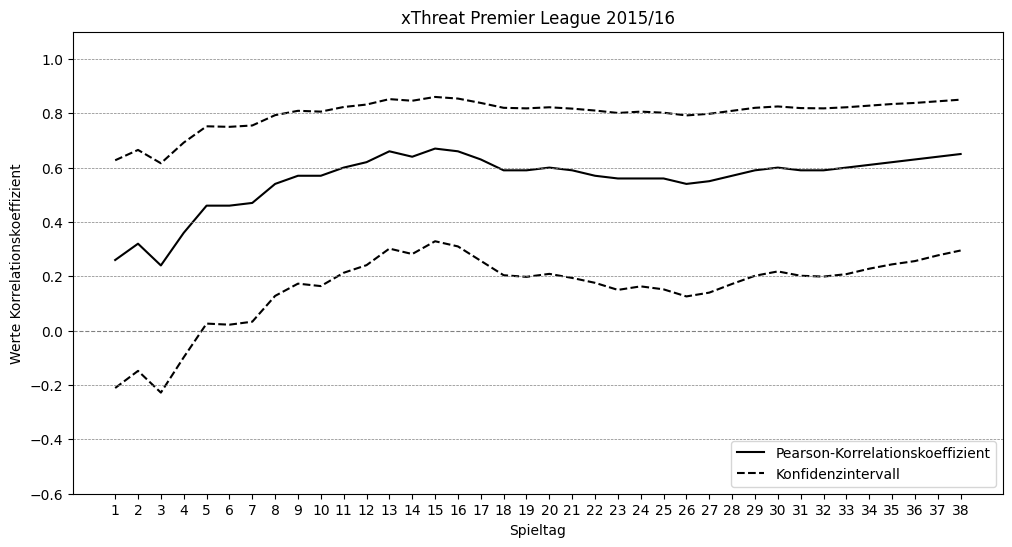

Diagram was saved succesfully /Users/andreas/Desktop/xThreat_Spieltag_Korrelation_Premier League.png


In [18]:
# Standard style (white background)
plt.style.use("default")

# Extract relevant data from DataFrame
spieltag_values = results_pear_df["Spieltag"].astype(int).tolist()
correlation_values = results_pear_df["Pearson Punktekorrelation"].tolist()
confidence_upper_value = results_pear_df["Konfidenzintervall upper Pearson"].tolist()
confidence_lower_value = results_pear_df["Konfidenzintervall lower Pearson"].tolist()

# Create diagram
plt.figure(figsize=(12, 6))
plt.plot(spieltag_values, correlation_values, linestyle='-', label='Pearson-Korrelationskoeffizient', color='black')
plt.plot(spieltag_values, confidence_upper_value, linestyle='dashed', label='Konfidenzintervall', color='black')
plt.plot(spieltag_values, confidence_lower_value, linestyle='dashed', label='', color='black')

# Set title
plt.title(f"xThreat {wettbewerbsname} 2015/16", color='black')

# Set axis titles
plt.xlabel("Spieltag", color='black')
plt.ylabel("Werte Korrelationskoeffizient", color='black')

# Set horizontal lines
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.8, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.6, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=-0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-0.4, color='gray', linestyle='--', linewidth=0.5)

plt.xticks(spieltag_values, rotation=0, color='black')
plt.yticks(color='black')

# Set boundaries
plt.ylim(-0.6, 1.1)

# Set legend
plt.legend(loc='lower right')

# Export diagram
desktop_path = os.path.expanduser("~/Desktop")
diagramm_path = os.path.join(desktop_path, f"xThreat_Spieltag_Korrelation_{wettbewerbsname}.png")
plt.savefig(diagramm_path, dpi=300, bbox_inches='tight', facecolor='white')

# Show diagram
plt.show()

print(f"Diagram was saved succesfully {diagramm_path}")
